<a href="https://colab.research.google.com/github/harihandika/Assesment-Pitjarus/blob/master/Copy_of_Color_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
import os

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.14.0


In [6]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"harihandika","key":"2d4c7068723ad523ab801d452dd203d8"}'}

In [7]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [8]:
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
! kaggle datasets download -d masouduut94/digikala-color-classification

 86% 31.0M/35.9M [00:00<00:00, 55.3MB/s]
100% 35.9M/35.9M [00:00<00:00, 62.3MB/s]


In [10]:
import zipfile
zip_ref = zipfile.ZipFile('digikala-color-classification.zip', 'r')
zip_ref.extractall('/kaggle/input/digikala-color-classification/')
zip_ref.close()

In [11]:
DATASET_PATH = "/kaggle/input/digikala-color-classification/"
print(os.listdir(DATASET_PATH))

['train']


In [12]:
!pip install torchsummary

In [13]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
from PIL import Image

In [14]:
data_dir = '/kaggle/input/digikala-color-classification/train'
colors = os.listdir(data_dir)
print(colors)

['black', 'red', 'orange', 'pink', 'purple', 'green', 'blue', 'grey', 'brown', 'silver', 'yellow', 'white']


In [15]:
num_labels = len(colors)

color_to_label = {
    color: idx for idx, color in enumerate(colors)
}

label_to_color = {
    idx: color for idx, color in enumerate(colors)
}

print(num_labels)
print(color_to_label)
print(label_to_color)

12
{'black': 0, 'red': 1, 'orange': 2, 'pink': 3, 'purple': 4, 'green': 5, 'blue': 6, 'grey': 7, 'brown': 8, 'silver': 9, 'yellow': 10, 'white': 11}
{0: 'black', 1: 'red', 2: 'orange', 3: 'pink', 4: 'purple', 5: 'green', 6: 'blue', 7: 'grey', 8: 'brown', 9: 'silver', 10: 'yellow', 11: 'white'}


In [16]:
def random_pick() -> tuple[np.ndarray, int]:
    color = random.choice(colors)
    img_fnames = os.listdir(f'{data_dir}/{color}')
    img_path = f'{data_dir}/{color}/{random.choice(img_fnames)}'

    img = Image.open(img_path).convert('RGB')
    img = np.asarray(img)
    label = color_to_label[color]
    return img, label

image_shape=(224, 224, 3)


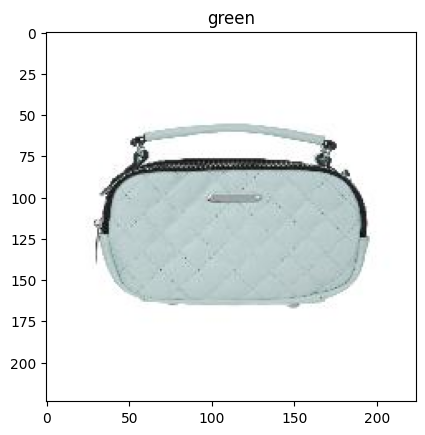

In [17]:
img, label = random_pick()
print(f'image_shape={img.shape}')
plt.imshow(img)
plt.title(label_to_color[label])
plt.show()


In [18]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [19]:
from torchvision import transforms

class ImageLoader:
    def __init__(self):
        self.transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]
        )

    def load(self, img_path):
        img = Image.open(img_path).convert('RGB')
        t_img = self.transform(img)
        return t_img

In [20]:
from torch.utils.data import Dataset, DataLoader, random_split

class ImageDataset(Dataset):

    data_dir = '/kaggle/input/digikala-color-classification/train'

    def __init__(self, image_loader):
        colors = os.listdir(self.data_dir)

        self.data = []
        for color in tqdm(colors):
            image_fnames = [i for i in os.listdir(f'{self.data_dir}/{color}') if not i.startswith('.')]
            for image_fname in image_fnames:
                img_path = f'{self.data_dir}/{color}/{image_fname}'
                t_img = image_loader.load(img_path)
                label = color_to_label[color]
                self.data.append((img_path, t_img, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [21]:
dataset = ImageDataset(ImageLoader())

100%|██████████| 12/12 [00:16<00:00,  1.38s/it]


In [22]:
dataset[0][1].shape

torch.Size([3, 224, 224])

In [23]:
val_ratio = 0.1
test_size = 30

val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - (val_size + test_size)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [24]:
print(f'train: {len(train_dataset)}, val: {len(val_dataset)}, test: {len(test_dataset)}')

train: 5586, val: 623, test: 30


In [25]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_size, shuffle=False)

In [26]:
import torch
import torch.nn as nn

In [27]:
import torch.nn as nn

class ColorClassifier(nn.Module):
    def __init__(self):
        super(ColorClassifier, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.3),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=2, stride=2, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(0.3),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=2, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=6, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout2d(0.3),
        )

        # Fully connected layers
        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 1 * 1, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
        )

        self.fc2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
        )

        self.fc3 = nn.Sequential(
            nn.Linear(256, num_labels)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [28]:
model = ColorClassifier().to(device)

In [29]:
from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,136
         MaxPool2d-2           [-1, 64, 28, 28]               0
       BatchNorm2d-3           [-1, 64, 28, 28]             128
              ReLU-4           [-1, 64, 28, 28]               0
         Dropout2d-5           [-1, 64, 28, 28]               0
            Conv2d-6          [-1, 128, 15, 15]          32,896
         MaxPool2d-7            [-1, 128, 5, 5]               0
       BatchNorm2d-8            [-1, 128, 5, 5]             256
              ReLU-9            [-1, 128, 5, 5]               0
        Dropout2d-10            [-1, 128, 5, 5]               0
           Conv2d-11            [-1, 256, 6, 6]         131,328
        MaxPool2d-12            [-1, 256, 1, 1]               0
      BatchNorm2d-13            [-1, 256, 1, 1]             512
             ReLU-14            [-1, 25

In [30]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters())

In [32]:
def train(model, criterion, optimizer, data_loader):
    model.train()
    train_loss, total, corrects = 0, 0, 0
    for _, inputs, labels in tqdm(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        preds = outputs.argmax(dim=1)
        total += len(inputs)
        corrects += (preds == labels).sum().item()

        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_accuracy = corrects / total

    return train_loss, train_accuracy

def evaluate(model, criterion, data_loader):
    model.eval()
    val_loss, total, corrects = 0, 0, 0
    with torch.no_grad():
        for _, inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = outputs.argmax(dim=1)
            total += len(inputs)
            corrects += (preds == labels).sum().item()

    val_loss /= len(data_loader)
    val_accuracy = corrects / total

    return val_loss, val_accuracy

In [ ]:
epochs = 30
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
for epoch in range(epochs):
    train_loss, train_accuracy = train(model, criterion, optimizer, train_loader)
    val_loss, val_accuracy = evaluate(model, criterion, val_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'epoch={epoch + 1}, train_loss={train_loss:.3f}, val_loss={val_loss:.3f}, train_accuracy={train_accuracy:.3f}, val_accuracy={val_accuracy:.3f}')

100%|██████████| 88/88 [02:08<00:00,  1.46s/it]


epoch=1, train_loss=1.988, val_loss=1.626, train_accuracy=0.328, val_accuracy=0.518


100%|██████████| 88/88 [02:02<00:00,  1.39s/it]


epoch=2, train_loss=1.429, val_loss=1.241, train_accuracy=0.518, val_accuracy=0.610


100%|██████████| 88/88 [02:03<00:00,  1.40s/it]


epoch=3, train_loss=1.285, val_loss=1.072, train_accuracy=0.574, val_accuracy=0.668


100%|██████████| 88/88 [02:04<00:00,  1.41s/it]


epoch=4, train_loss=1.208, val_loss=0.997, train_accuracy=0.606, val_accuracy=0.676


100%|██████████| 88/88 [02:03<00:00,  1.40s/it]


epoch=5, train_loss=1.148, val_loss=1.000, train_accuracy=0.631, val_accuracy=0.661


100%|██████████| 88/88 [02:07<00:00,  1.45s/it]


epoch=6, train_loss=1.098, val_loss=0.946, train_accuracy=0.640, val_accuracy=0.679


100%|██████████| 88/88 [02:01<00:00,  1.38s/it]


epoch=7, train_loss=1.068, val_loss=0.946, train_accuracy=0.648, val_accuracy=0.693


100%|██████████| 88/88 [02:03<00:00,  1.40s/it]


epoch=8, train_loss=1.067, val_loss=0.883, train_accuracy=0.655, val_accuracy=0.709


100%|██████████| 88/88 [02:04<00:00,  1.42s/it]


epoch=9, train_loss=1.033, val_loss=0.910, train_accuracy=0.657, val_accuracy=0.685


100%|██████████| 88/88 [02:07<00:00,  1.45s/it]


epoch=10, train_loss=1.021, val_loss=0.851, train_accuracy=0.669, val_accuracy=0.727


100%|██████████| 88/88 [02:06<00:00,  1.43s/it]


epoch=11, train_loss=1.000, val_loss=0.859, train_accuracy=0.677, val_accuracy=0.724


100%|██████████| 88/88 [02:07<00:00,  1.45s/it]


epoch=12, train_loss=0.975, val_loss=0.850, train_accuracy=0.682, val_accuracy=0.726


100%|██████████| 88/88 [02:06<00:00,  1.44s/it]


epoch=13, train_loss=0.964, val_loss=0.807, train_accuracy=0.686, val_accuracy=0.734


 61%|██████▏   | 54/88 [01:17<00:47,  1.39s/it]

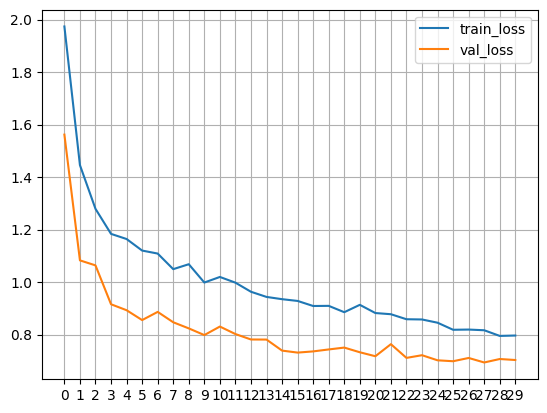

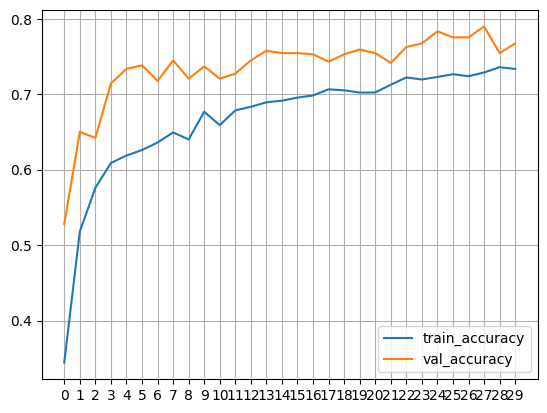

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), train_losses)
plt.plot(range(epochs), val_losses)
plt.legend(['train_loss', 'val_loss'])
plt.xticks(range(epochs))
plt.grid(True)
plt.show()

plt.plot(range(epochs), train_accuracies)
plt.plot(range(epochs ), val_accuracies)
plt.legend(['train_accuracy', 'val_accuracy'])
plt.xticks(range(epochs))
plt.grid(True)
plt.show()

In [ ]:
from torch.utils.data import Subset

sample_data = Subset(test_dataset, range(30))
sample_loader = DataLoader(sample_data, batch_size=30)

In [ ]:
import math

def plot_images(model, img_paths, t_imgs, labels = None):
    _, axes = plt.subplots(
        math.ceil(len(img_paths) / 5),
        5,
        figsize=(15, 5 * math.ceil(len(img_paths) / 5)),
    )
    plt.tick_params(left=False, right=False, bottom=False)
    outputs = model(t_imgs.to(device))
    outputs = torch.softmax(outputs, dim=1)

    preds = outputs.argmax(1)
    best_indices = outputs.argsort(dim=1, descending=True)

    for i in range(len(preds)):
        img = Image.open(img_paths[i]).convert('RGB')
        axes[i // 5, i % 5].imshow(img)
        axes[i // 5, i % 5].set_xticks([])
        axes[i // 5, i % 5].set_yticks([])

        best_idx0 = best_indices[i][0].item()
        best_idx1 = best_indices[i][1].item()
        title = ''
        if labels is not None:
            title += f'true: {label_to_color[labels[i].item()]}\n'
        title += '-' * 20 + '\n'
        title += f'{label_to_color[best_idx0]}: {outputs[i, best_idx0]:.3f}\n'
        title += f'{label_to_color[best_idx1]}: {outputs[i, best_idx1]:.3f}\n'
        axes[i // 5, i % 5].set_title(title)

    plt.show()

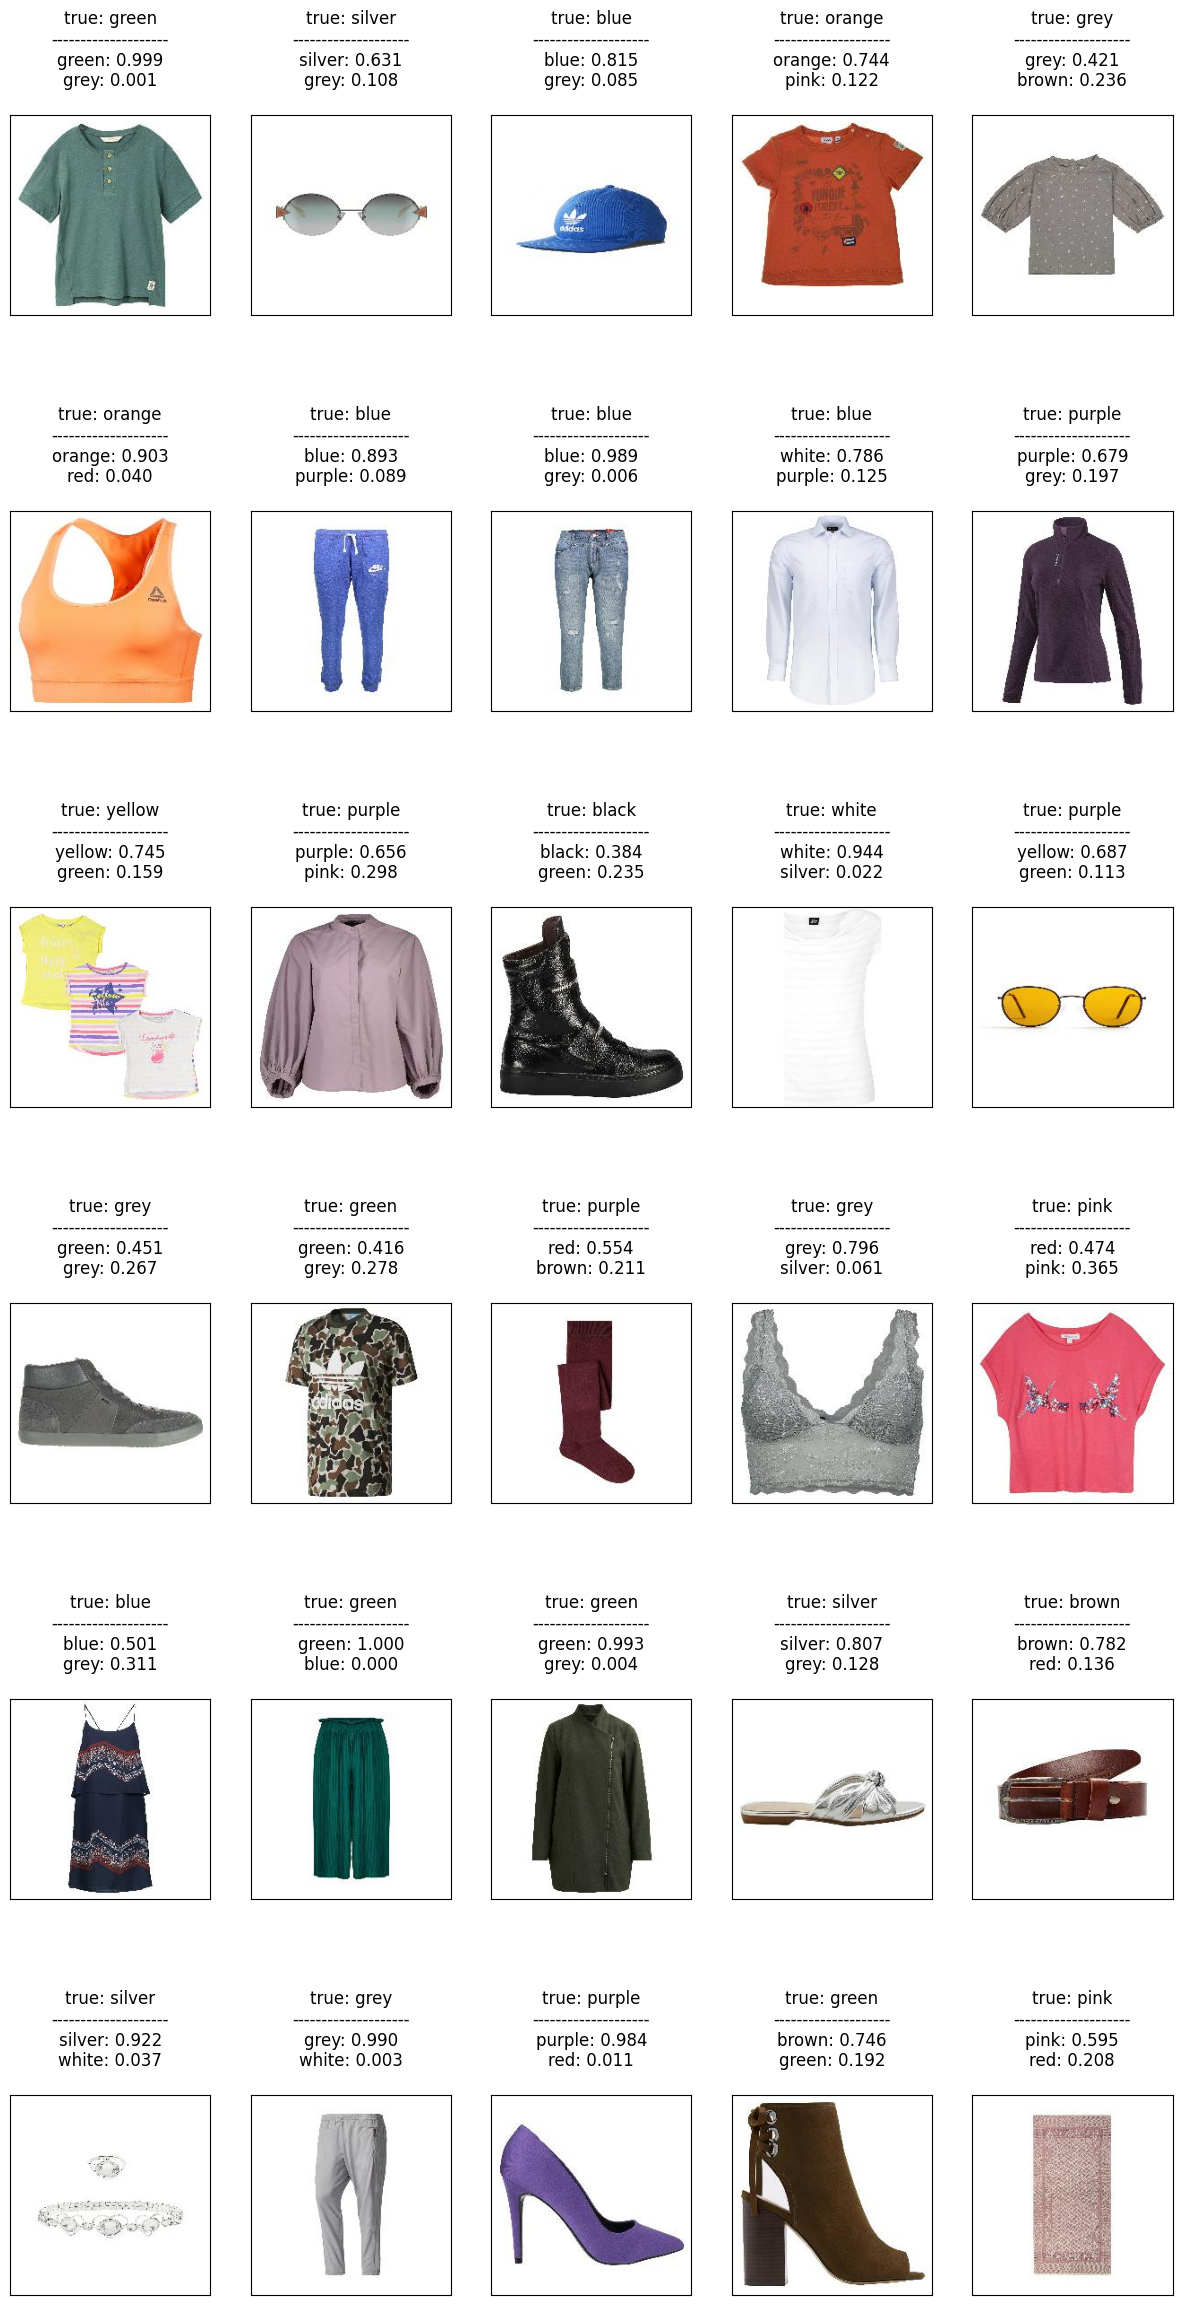

In [ ]:
with torch.no_grad():
    for img_paths, t_imgs, labels in test_loader:
        plot_images(model, img_paths, t_imgs, labels)

In [ ]:
# Mount Google Drive to access your image
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import torch

# Assuming your model is named 'model'
model_path = '/content/gdrive/MyDrive/model_colorrr.pth'
torch.save(model.state_dict(), model_path)

In [ ]:
import torch
import h5py

# Assuming your PyTorch model state dictionary is named 'state_dict'
model_state_dict_path = '/content/gdrive/MyDrive/model_colorrr.pth'

# Load the PyTorch model state dictionary
state_dict = torch.load(model_state_dict_path)

# Create an HDF5 file
h5_file_path = '/content/gdrive/MyDrive/model_colorrr.h5'
with h5py.File(h5_file_path, 'w') as h5_file:
    # Iterate through the items in the state dictionary and save the weights
    for name, param in state_dict.items():
        h5_file.create_dataset(name, data=param.cpu().numpy())


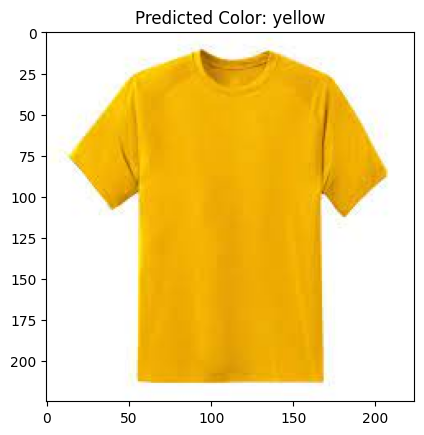

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the trained PyTorch model
model_path = "/content/gdrive/MyDrive/model_colorrr.pth"
model = ColorClassifier()  # Replace with the actual class of your PyTorch model
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

# Define color mapping
color_mapping = {0: 'purple', 1: 'yellow', 2: 'orange', 3: 'black', 4: 'white', 5: 'blue', 6: 'red', 7: 'brown', 8: 'pink', 9: 'green', 10: 'silver', 11: 'grey'}

# Image preprocessing function
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img)
    img_tensor = torch.unsqueeze(img_tensor, 0)
    return img_tensor

# Function to classify and display color
def classify_and_display(image_path):
    # Preprocess the image
    img_tensor = preprocess_image(image_path)

    # Make predictions
    with torch.no_grad():
        predictions = model(img_tensor)

    # Get the predicted color label
    predicted_label = torch.argmax(predictions).item()

    # Map the label to the color
    predicted_color = color_mapping[predicted_label]

    # Display the image and predicted color
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(f'Predicted Color: {predicted_color}')
    plt.show()

# Example usage
uploaded_image_path = "/content/black 2.jpg"  # Replace with the path to the uploaded image
classify_and_display(uploaded_image_path)
